In [1]:
from spiketimes.utils import p_adjust
from citalopram_project.load import get_data_dir, load_neurons, load_spikes
from citalopram_project.correlations import pairwise_correlation_spikes
# from citalopram_project.transforms import bin_spikes_interval, pivot, 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()
sns.set_style("ticks")

neurons = load_neurons()
neurons = neurons.loc[lambda x: x.group.isin(["sal", "continuation"])]
df_ensembles = pd.read_parquet(get_data_dir() / "derived" / "spont_ensembles.parquet.gzip")
spikes = load_spikes(block_name="pre").merge(neurons[["neuron_id", "session_name"]]).loc[lambda x: x.spiketimes < (60 * 30)]

In [2]:
def get_idx(ensemble_df, neuron_df):
    return (
        neuron_df[["neuron_id", "session_name"]]
        .merge(ensemble_df, how="left")
        .fillna(-100)
        .sort_values("ensemble_id")
        .neuron_id.values
    )

def _reindex(df: pd.DataFrame, idx: np.ndarray) -> pd.DataFrame:
    df = df.reindex(idx)
    df = df[idx]
    return df



sessions = neurons.session_name.unique()
session = sessions[2]

neurons_sesh = neurons.loc[lambda x: x.session_name == session]
spikes_sesh = spikes.loc[lambda x: x.session_name == session]
ensembles_sesh = df_ensembles.loc[lambda x: x.session_name == session]
df_corr = pairwise_correlation_spikes(spikes_sesh, bin_width=1, sigma=0, fillna=0)

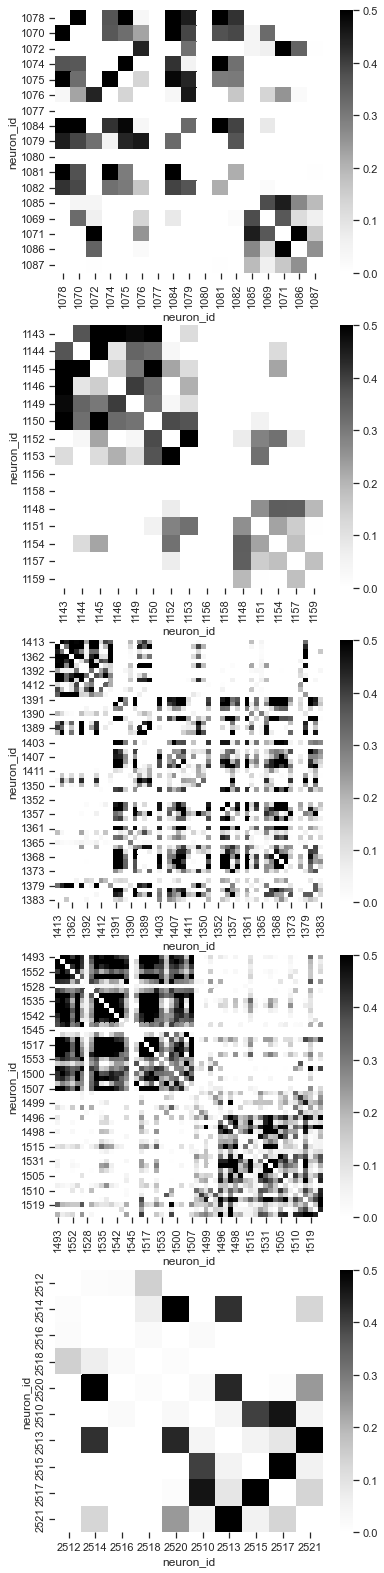

In [3]:
sessions = neurons.loc[lambda x: x.group =="sal"].session_name.unique()
_, axes = plt.subplots(nrows=len(sessions), figsize=(6, 28))
for i, session in enumerate(sessions):
    neurons_sesh = neurons.loc[lambda x: x.session_name == session]
    spikes_sesh = spikes.loc[lambda x: x.session_name == session]
    ensembles_sesh = df_ensembles.loc[lambda x: x.session_name == session]
    idx = get_idx(ensembles_sesh, neurons_sesh)
    df_corr = pairwise_correlation_spikes(spikes_sesh, bin_width=1, sigma=1, fillna=0, rectify=True)
    sns.heatmap(_reindex(df_corr, idx), cmap="Greys", vmin=0, vmax=0.5, ax=axes[i])

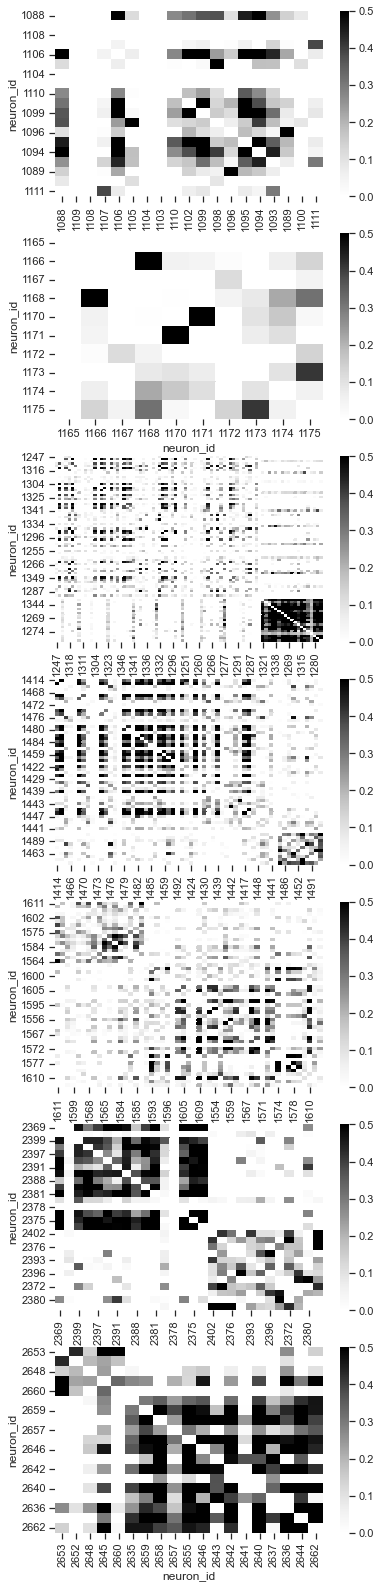

In [4]:
sessions = neurons.loc[lambda x: x.group =="continuation"].session_name.unique()
_, axes = plt.subplots(nrows=len(sessions), figsize=(6, 28))
for i, session in enumerate(sessions):
    neurons_sesh = neurons.loc[lambda x: x.session_name == session]
    spikes_sesh = spikes.loc[lambda x: x.session_name == session]
    ensembles_sesh = df_ensembles.loc[lambda x: x.session_name == session]
    idx = get_idx(ensembles_sesh, neurons_sesh)
    df_corr = pairwise_correlation_spikes(spikes_sesh, bin_width=1, sigma=1, fillna=0, rectify=True)
    sns.heatmap(_reindex(df_corr, idx), cmap="Greys", vmin=0, vmax=0.5, ax=axes[i])

In [5]:
df_stats = pd.read_parquet(get_data_dir() / "derived" / "spont_ensemble_stats.parquet.gzip")



In [7]:
from citalopram_project.load import load_eeg, load_neurons

df = load_eeg("pre")

In [9]:
df[["session_name"]].drop_duplicates().merge(load_neurons()[["session_name", "group"]].drop_duplicates()).groupby("group").apply(len)

group
continuation       6
discontinuation    4
sal                5
dtype: int64

In [61]:
from scipy.stats import mannwhitneyu


df = df_stats.merge(neurons[["session_name", "group"]].drop_duplicates()).loc[lambda x: x.ensemble_sig]
x = df[df["group"] == "continuation"]["simmilarity"]
y = df[df["group"] == "sal"]["simmilarity"]

print(mannwhitneyu(x, y))

# x = df[df["group"] == "continuation"]["score"]
# y = df[df["group"] == "sal"]["score"]

# print(mannwhitneyu(x, y))

MannwhitneyuResult(statistic=39.0, pvalue=0.46481826225353534)


In [31]:
def avg_distance(neurons, df_distance):
    return df_distance.loc[lambda x: x.neuron1.isin(neurons) & x.neuron2.isin(neurons)]["distance"].median()


df_distance = pd.read_parquet(get_data_dir() / "distances.parquet.gzip")


In [32]:
df = (
    df_ensembles
    .groupby("ensemble_id", as_index=False)["neuron_id"]
    .apply(avg_distance, df_distance=df_distance)
    .rename(columns={"neuron_id": "distance",})
    .merge(df_stats)
    .merge(neurons[["session_name", "group"]].drop_duplicates())
)

In [34]:
from scipy.stats import mannwhitneyu

x = df[df["group"] == "continuation"]["distance"]
y = df[df["group"] == "sal"]["distance"]

print(x.median())
print(y.median())

print(mannwhitneyu(x, y))

254.95097567963924
226.12220147522004
MannwhitneyuResult(statistic=16.0, pvalue=0.015217011324251758)


In [41]:
def homogeneity(ser):
    return (ser == ser.mode().values[0]).mean()


df_footshock = pd.read_csv(get_data_dir() / "derived" / "footshock_slow_timescale.csv")
df_footshock["response"] = np.where(df_footshock["sig"] == True, np.where(df_footshock["statistic"] < 0, "activated", "inhibited"), "Non Responder")

In [55]:
df = (
    df_ensembles
    .merge(df_footshock)
    .groupby("ensemble_id",  as_index=False)["response"]
    .apply(homogeneity)
    .rename(columns={"response": "fs_homogeneity",})
    .merge(df_stats)
    .merge(load_neurons()[["session_name", "group"]].drop_duplicates())
)

In [56]:
x = df[df["group"] == "continuation"]["fs_homogeneity"]
y = df[df["group"] == "sal"]["fs_homogeneity"]

print(x.median())
print(y.median())

print(mannwhitneyu(x, y))

0.7
0.5591085271317829
MannwhitneyuResult(statistic=17.0, pvalue=0.35644033187753676)


In [58]:
df = (
    df_ensembles
    .merge(load_neurons())
    .groupby("ensemble_id",  as_index=False)["cluster"]
    .apply(homogeneity)
    .rename(columns={"cluster": "unit_homogeneity",})
    .merge(df_stats)
    .merge(load_neurons()[["session_name", "group"]].drop_duplicates())
)

x = df[df["group"] == "continuation"]["unit_homogeneity"]
y = df[df["group"] == "sal"]["unit_homogeneity"]

print(x.median())
print(y.median())

print(mannwhitneyu(x, y))

0.6
0.5769230769230769
MannwhitneyuResult(statistic=34.0, pvalue=0.29716629497418856)
